In [206]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter
import textwrap
import bitsandbytes
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from transformers.utils import logging

logging.set_verbosity_error()

In [207]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

2025-07-07 15:29:24.055490: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.3 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 4.0 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 4.3 MB/s eta 0:00:03
     ----------- ---------------------------- 3.7/12.8 MB 4.4 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 4.4 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 4.5 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 4.5 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 4.6 MB/s eta 0:00:02
     --------------------------- ------------ 8.7/12.8 MB 4.6 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 4.6 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 4.7 MB/

In [208]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 

    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]

    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_grouped_bar_chart(indices, group1, group2, title, xlabel, ylabel):
    width = 0.35
    x = np.arange(len(indices))

    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, group1, width, label='Group 1', color='cornflowerblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, group2, width, label='Group 2', color='lightcoral', edgecolor='black')

    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, rotation=90, ha='center', fontsize=10)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=1000,height=500,background_color='white',colormap='viridis',prefer_horizontal=0.9,scale=2,font_step=1).generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=24, fontweight='bold', pad=20)
    plt.tight_layout(pad=5)
    plt.show()

In [209]:
def combine_keywords(df):
    author_kws = df['Author Keywords'].fillna('').str.split(';')
    index_kws = df['Index Keywords'].fillna('').str.split(';')

    stop_keywords = {'man', 'woman', 'male', 'follow up', 'female', 'nonhuman', 'surveys', 'young adult', 'human', 'study', 'method', 'algorithms', 'article', 'adult', 'simple++', 'humans', "'current"}
    combined_keywords = []

    for a_kws, i_kws in zip(author_kws, index_kws):
        kws = set()
        if a_kws:
            kws.update([kw.strip().lower() for kw in a_kws if kw])
        if i_kws:
            kws.update([kw.strip().lower() for kw in i_kws if kw])
        kws = {kw for kw in kws if kw not in stop_keywords}
        combined_keywords.append(list(kws))

    return combined_keywords

### 1. Loading the articles data from Scopus: having 500 articles from each year from 2015-2025 - 5500 articles in total

In [210]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df['Combined Keywords'] = combine_keywords(articles_df)
articles_df.head(10)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords,Combined Keywords
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN,"[unstructured data, autoencoder, text mining, ..."
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...,"[natural language processing systems, key feat..."
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN,"[deep learning, natural language processing, h..."
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...,"[law enforcement, knowledge graph, application..."
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...,"[application programs, natural language proces..."
5,Zhao X.; Li L.; Wang Y.-X.,"Zhao, Xuandong (57552407600); Li, Lei (5609407...",57552407600; 56094074700; 58912060300,Distillation-Resistant Watermarking for Model ...,2022,Findings of the Association for Computational ...,https://www.scopus.com/inward/record.uri?eid=2...,How can we protect the intellectual property o...,NaN,Classification (of information); Computational...,"[original model, prediction probabilities, par..."
6,Latha B.; Nivedha B.; Ranjanaa Y.,"Latha, B. (26643194000); Nivedha, B. (57202678...",26643194000; 57202678926; 58127747300,Visual Audio Summarization Based on NLP Models,2022,2022 1st International Conference on Computati...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) uses compute...,Abstractive; comparison; extractive; Natural L...,Visual languages; Abstractive; Audio summariza...,"[audio summarization, natural language process..."
7,Rajan A.; Salgaonkar A.,"Rajan, Annie (57215688946); Salgaonkar, Ambuja...",57215688946; 35485507600,Survey of NLP Resources in Low-Resource Langua...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Research results in different subdomains of NL...,Konkani language; Natural language processing;...,NaN,"[nepali language, sindhi language, konkani lan..."
8,Desai N.P.; Dabhi V.K.,"Desai, Nikita P. (26639236000); Dabhi, Vipul K...",26639236000; 24823939300,Resources and components for gujarati NLP syst...,2022,Artificial Intelligence Review,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) represents t...,Components; Corpus; Gujarati; Indian language;...,Digital storage; Fake detection; Surveys; Auto...,"[fake detection, natural la

In [211]:
abstracts = articles_df['Abstract'].dropna().tolist()

### 2. Pre-processing the article's abstracts

In [212]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


['With artificial intelligence permeating conversations and marketing interactions through digital technologies and media, machine learning models, in particular, natural language processing (NLP) models, have surged in popularity for analyzing unstructured data in marketing. Yet, we do not fully understand which NLP models are appropriate for which marketing applications and what insights can be best derived from them. We review different NLP models and their applications in marketing. We layout the advantages and disadvantages of these models and highlight the conditions under which different models are appropriate in the marketing context. We introduce the latest neural autoencoder NLP models, demonstrate these models to analyze new product announcements and news articles, and provide an empirical comparison of the different autoencoder models along with the statistical NLP models. We discuss the insights from the comparison and offer guidelines for researchers. We outline future ex

### 3. Extracting the most common words in abstracts using TF-IDF

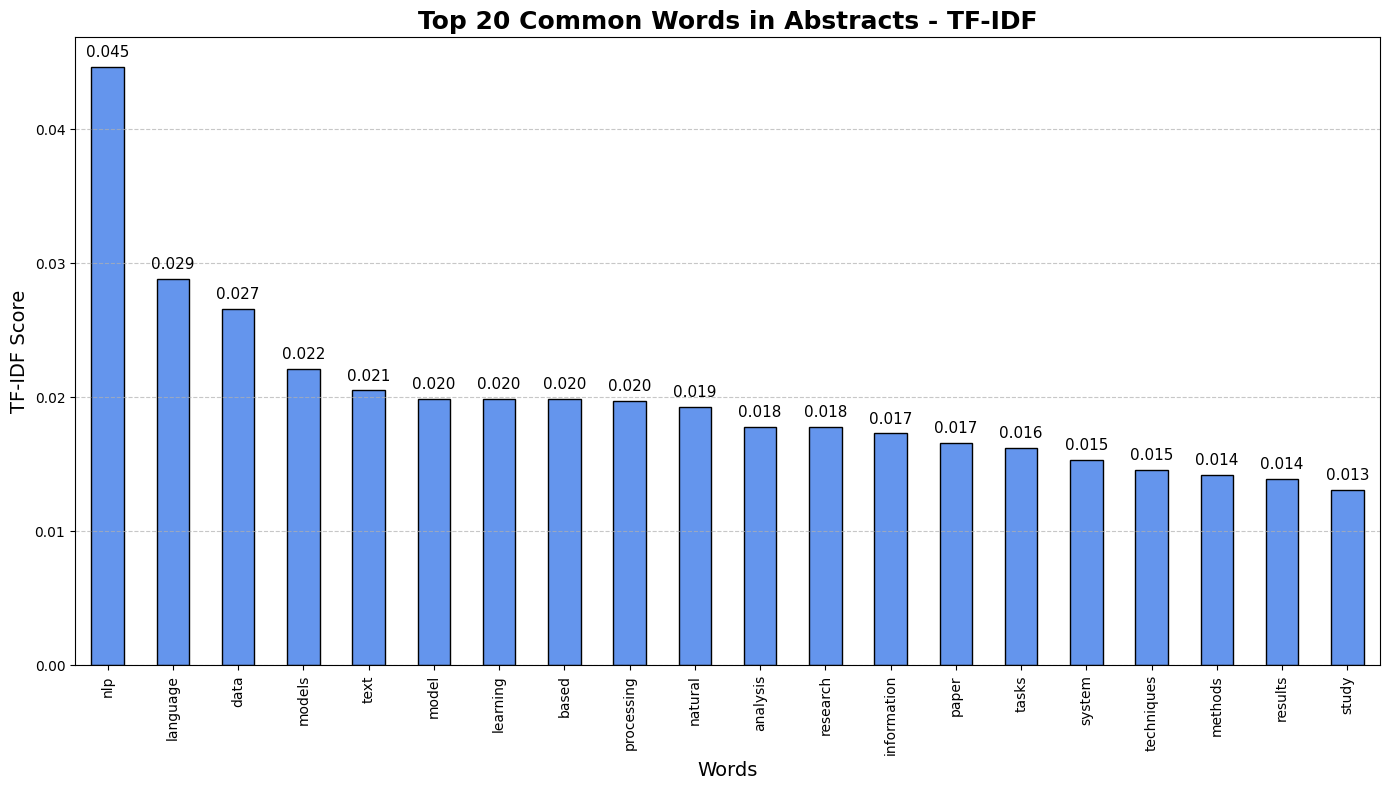

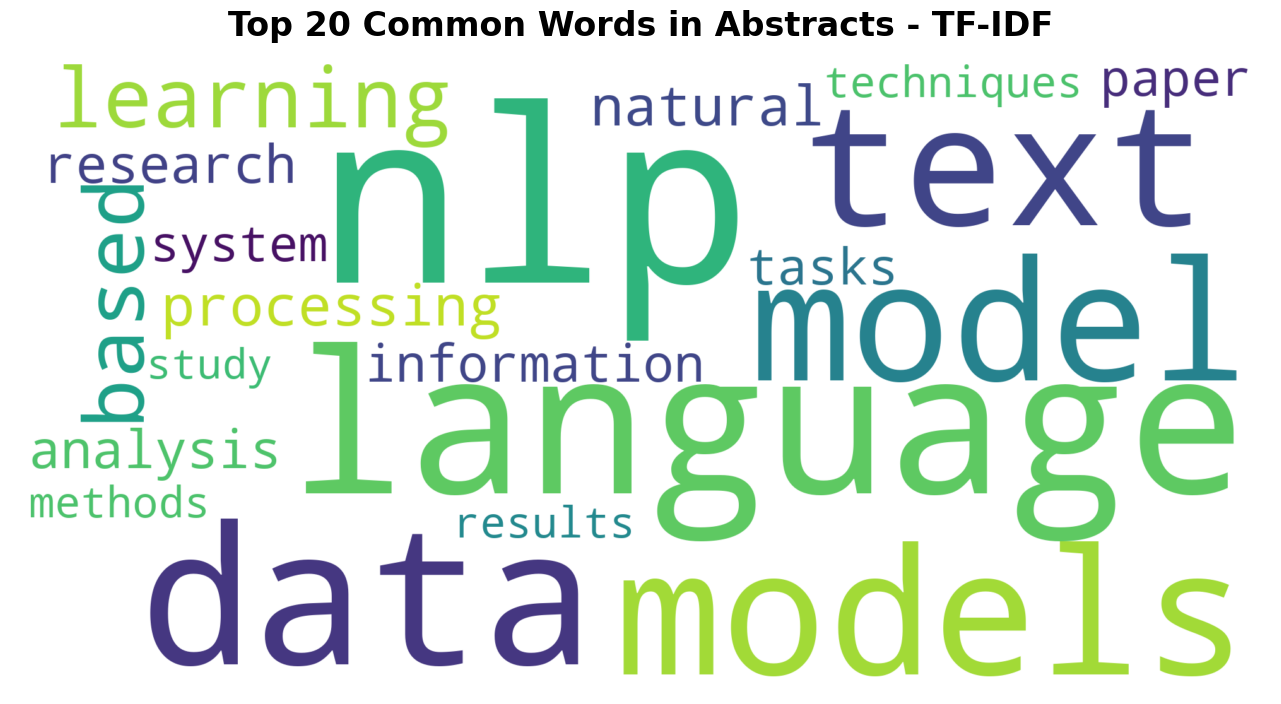

In [213]:
def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
create_bar_chart(pd.Series(top_words_df['score'].values, index=top_words_df['word']), "Top 20 Common Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Common Words in Abstracts - TF-IDF")


### 4. Extracting the most common words in abstracts using Word2Vec

[('nlp', 15612), ('language', 6962), ('data', 4948), ('processing', 4437), ('natural', 4283), ('based', 3842), ('models', 3380), ('text', 3232), ('model', 3186), ('learning', 2969), ('research', 2790), ('analysis', 2782), ('paper', 2680), ('information', 2574), ('results', 2537), ('methods', 2224), ('study', 2190), ('system', 2114), ('tasks', 2081), ('techniques', 2031), ('use', 1797), ('approach', 1795), ('performance', 1735), ('machine', 1638), ('method', 1524), ('different', 1471), ('systems', 1458), ('clinical', 1455), ('accuracy', 1417), ('task', 1404), ('proposed', 1327), ('applications', 1321), ('word', 1310), ('work', 1294), ('classification', 1224), ('time', 1221), ('computational', 1194), ('knowledge', 1170), ('process', 1152), ('ieee', 1117), ('new', 1101), ('sentiment', 1095), ('tools', 1073), ('large', 1049), ('human', 1022), ('training', 1020), ('deep', 1006), ('association', 1004), ('semantic', 1000), ('problem', 997), ('domain', 992), ('extraction', 984), ('features', 9

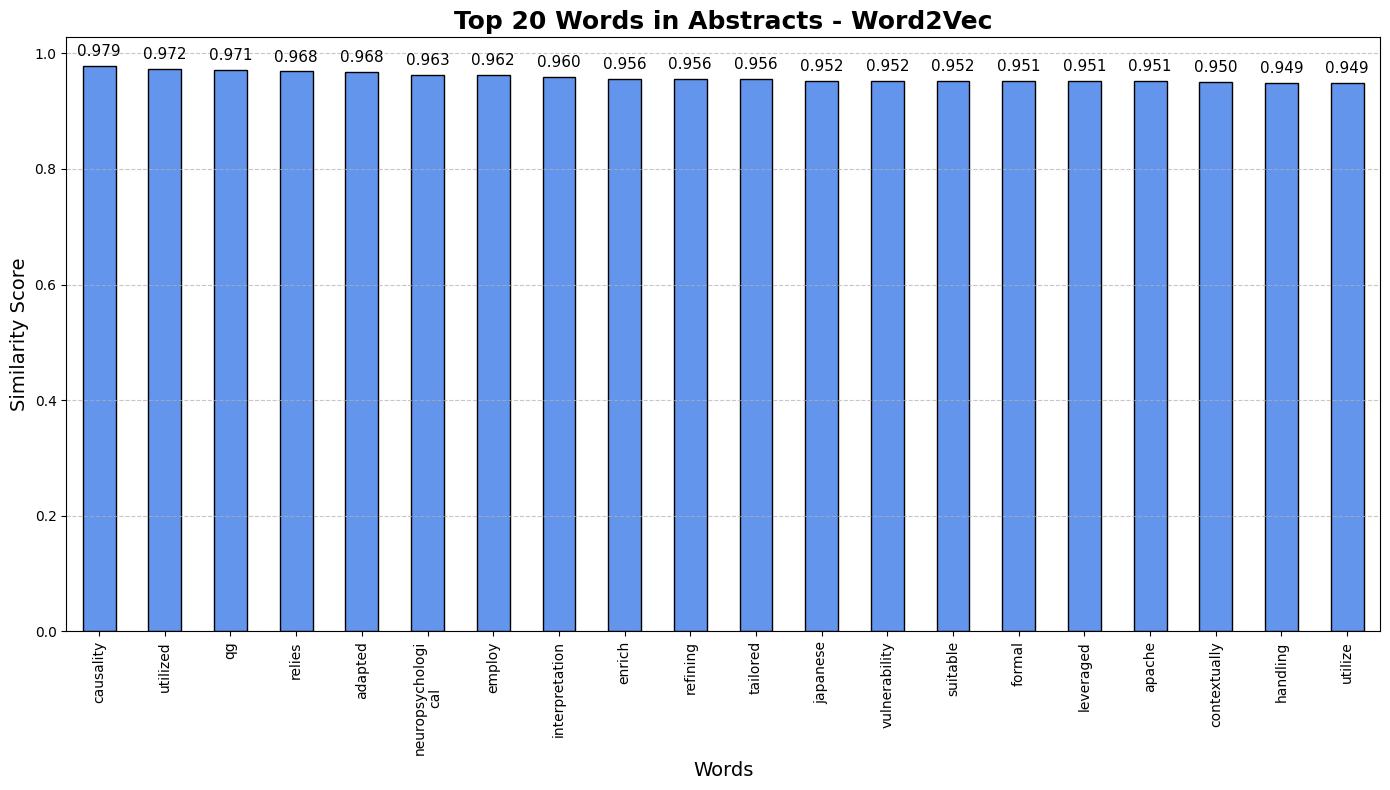

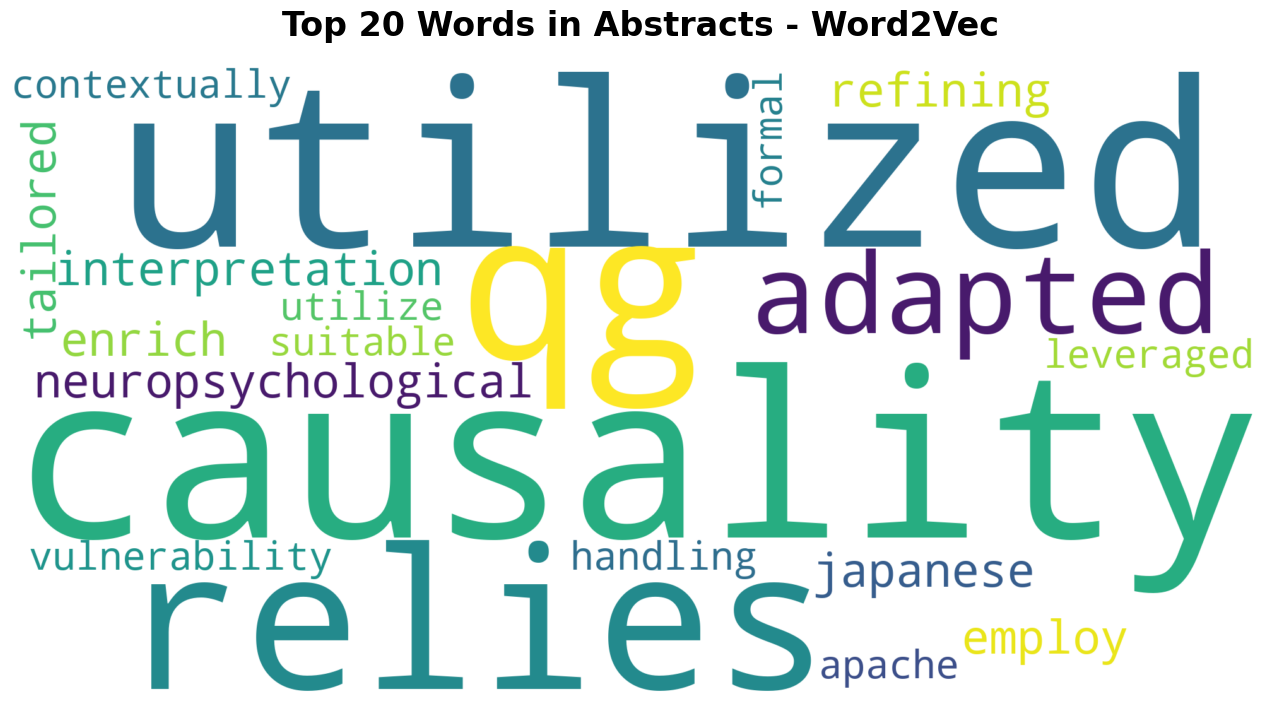

In [214]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=3, workers=4)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
top_100_words = model.wv.index_to_key[:100]
top_100_words_with_counts = [(word, model.wv.get_vecattr(word, "count")) for word in top_100_words]
print(top_100_words_with_counts)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


### 5. Extracting the most common words in abstracts using AutoEncoder
### I have picked up the important words - the words that the decoder had the most trouble reconstructing - thus are more complex

378/378 [==============================] - 1s 1ms/step
Top 20 words with highest reconstruction error:


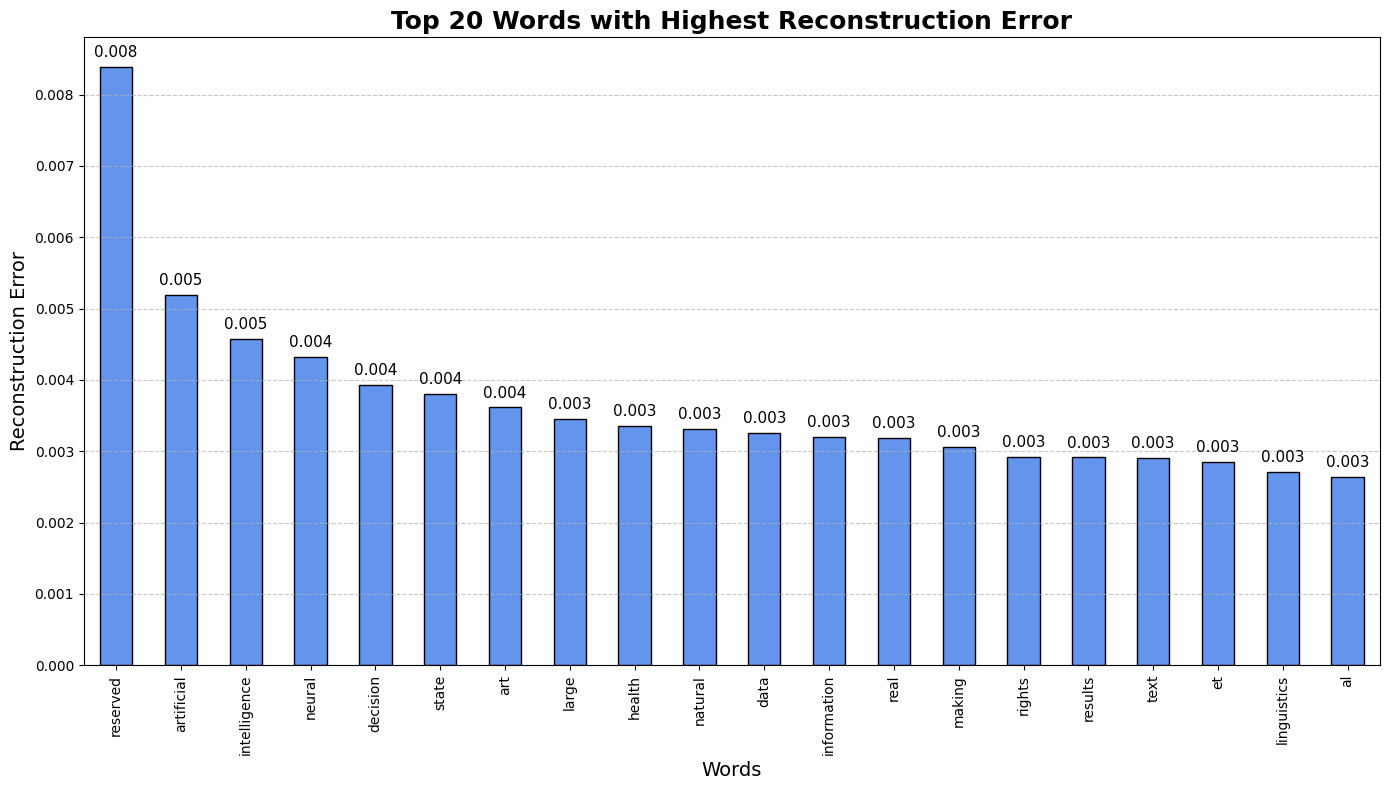

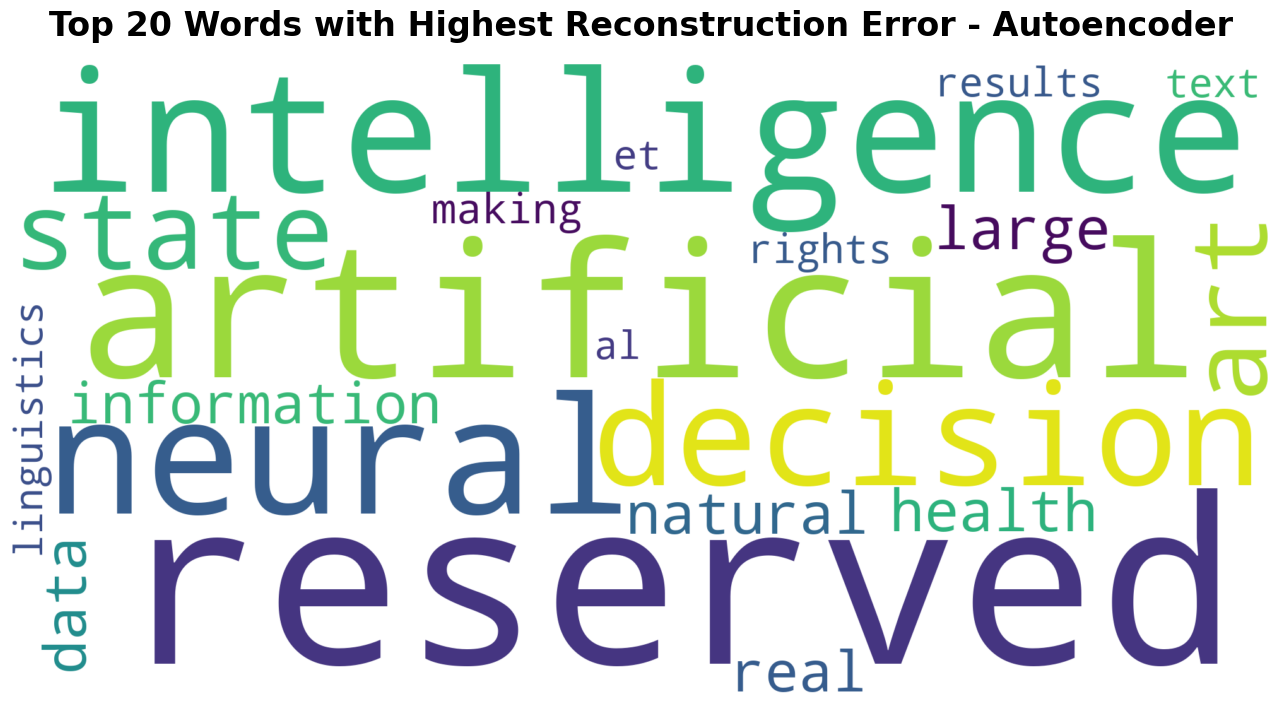

In [215]:
words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)

predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))
word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)
print(f"Top 20 words with highest reconstruction error:")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

### 6. The differences between 3-5

In [216]:
# comparing the top words from TF-IDF, Word2Vec, and Autoencoder
top_tfidf_words = set(top_words_df['word'])
top_word2vec_words = set(word for word, _ in similar_words)
top_autoencoder_words = set(word for word, _ in word_errors_sorted[:20])
common_words = top_tfidf_words.intersection(top_word2vec_words).intersection(top_autoencoder_words)
print(f"Common words in all three methods: {common_words}")
print(f"Common words in TF-IDF and autoencoder: {top_tfidf_words.intersection(top_autoencoder_words)}")

Common words in all three methods: set()
Common words in TF-IDF and autoencoder: {'data', 'information', 'results', 'text', 'natural'}


### 7. NER

In [217]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

In [218]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")
for (ent, label), count in entity_counter.most_common(20):
    print(f"{ent} ({label}): {count}")
org_counter = Counter([ent for ent, label in entities if label == "ORG"])
common_orgs = set(org for org, count in org_counter.items() if count >= 20)
print("Common ORGs:", common_orgs)


Top 20 entities seen with their types:
NLP (ORG): 14499
two (CARDINAL): 1047
first (ORDINAL): 637
three (CARDINAL): 620
Natural Language Processing (ORG): 604
AI (ORG): 489
English (LANGUAGE): 464
2015 (DATE): 451
2019 (DATE): 418
BERT (ORG): 416
2017 (DATE): 397
2018 (DATE): 376
2025 (DATE): 371
2021 (DATE): 362
2022 (DATE): 348
2 (CARDINAL): 336
one (CARDINAL): 331
2020 (DATE): 324
ML (ORG): 305
1 (CARDINAL): 303
Common ORGs: {'Oxford University Press', 'CI', 'Springer International Publishing', 'European Language Resources Association', 'WSD', 'IOS Press', 'Transformer', 'IR', 'Logistic Regression', 'EEG', 'IGI Global', 'linear', 'IGI Global Scientific Publishing', 'RDF', 'ADR', 'Natural Language Processing', 'Deep Learning', 'Support Vector Machine', 'SRL', 'Springer International Publishing AG', 'YouTube', 'DL', 'ACM', 'PubMed', 'Convolutional Neural Network', 'FL', 'p < 0.001', '2023 Association for Computational Linguistics', 'IBM', 'Google Scholar', 'ROUGE', 'NMPC', 'Springer I

# 8.EDA

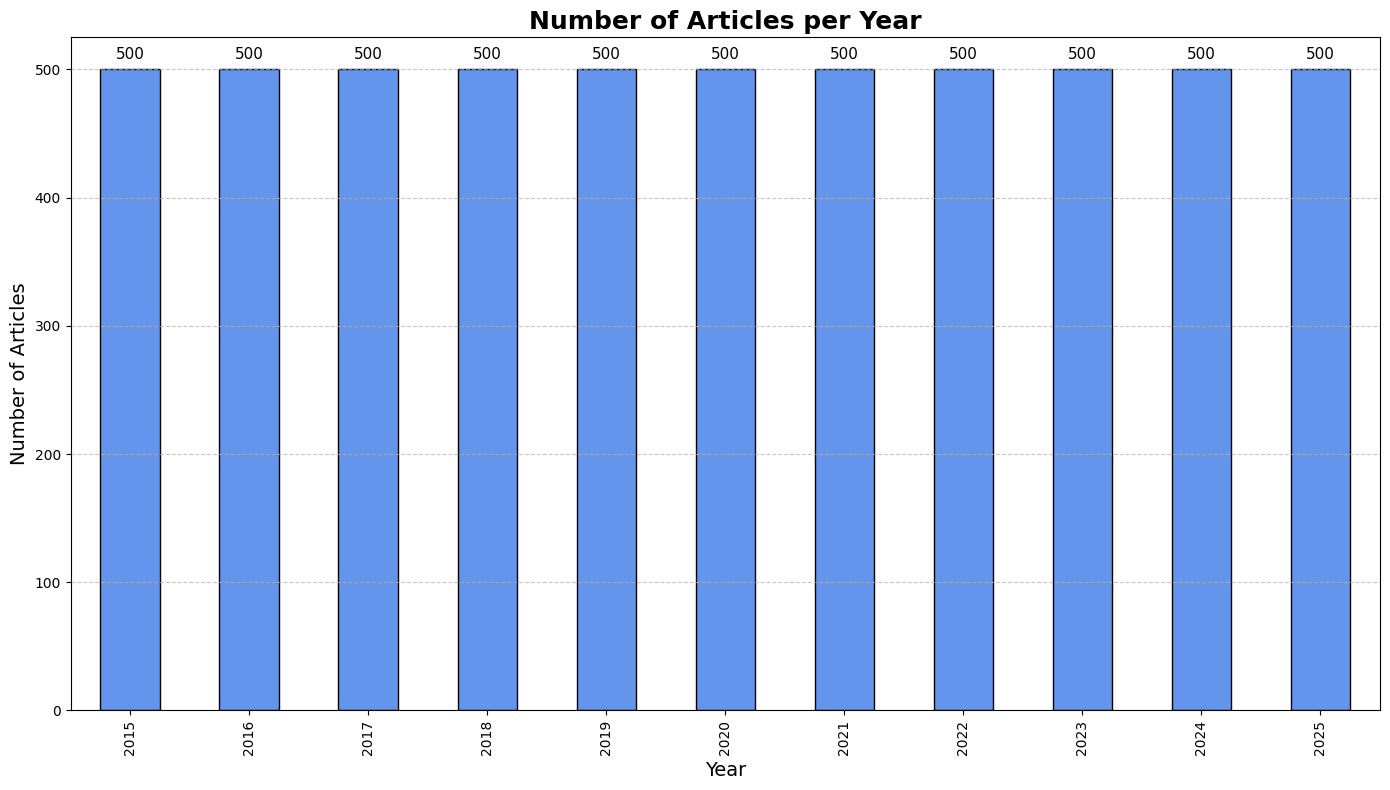

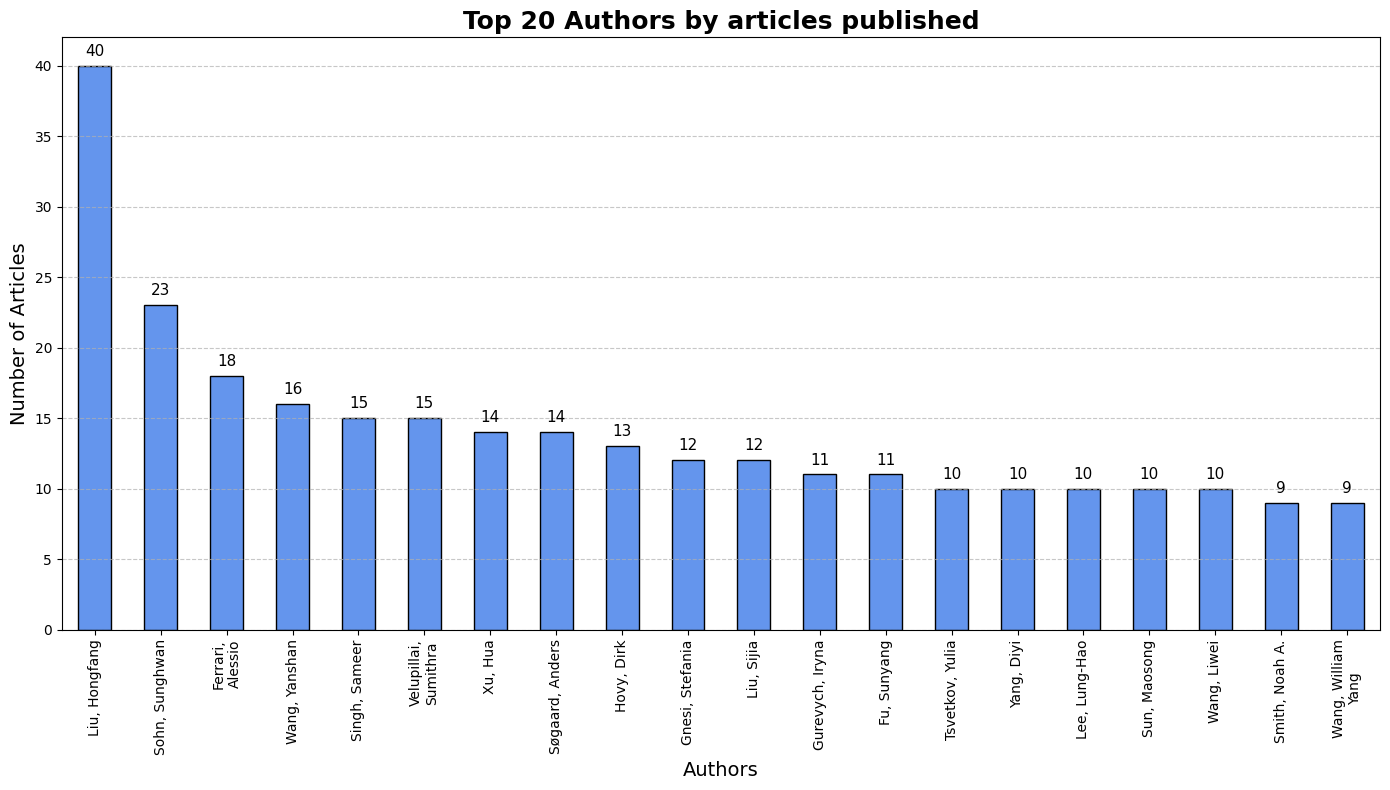

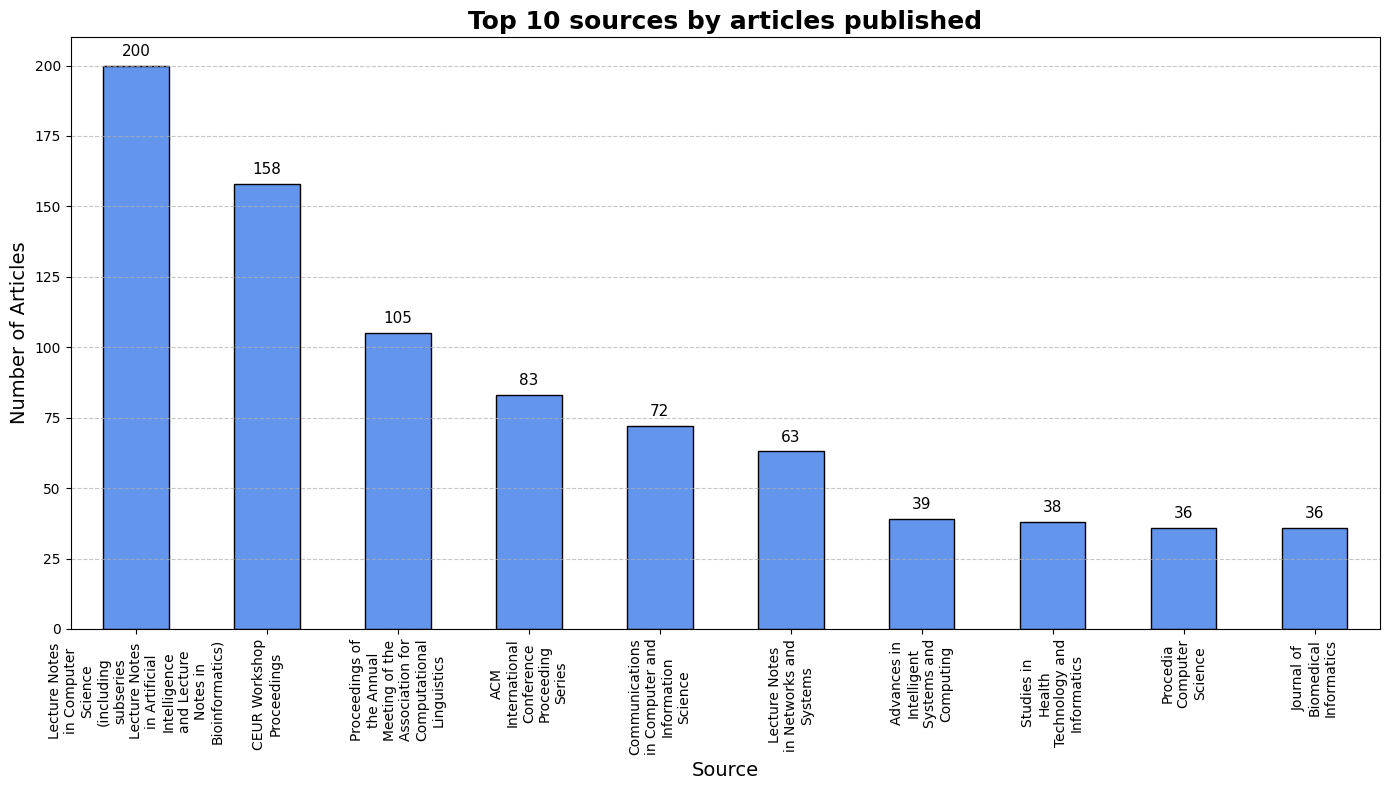

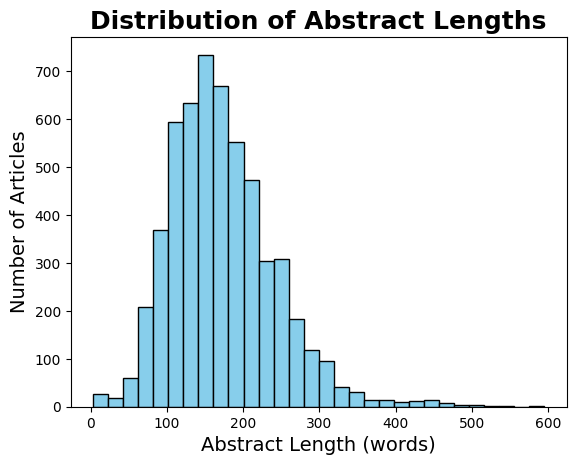

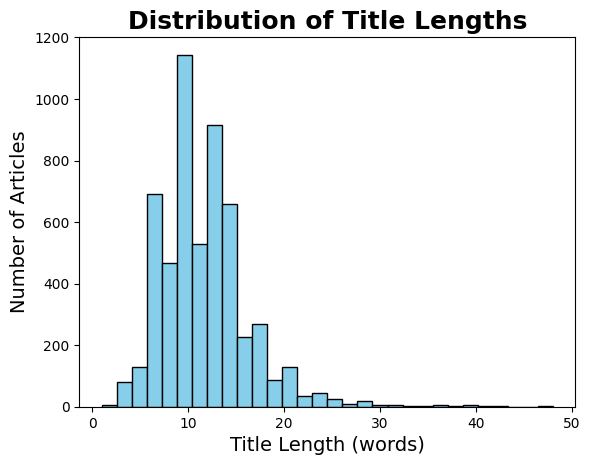

In [219]:
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(20)
create_bar_chart(top_authors, "Top 20 Authors by articles published", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 sources by articles published", "Source", "Number of Articles")

abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

title_lengths = articles_df['Title'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(title_lengths, "Distribution of Title Lengths", "Title Length (words)", "Number of Articles")



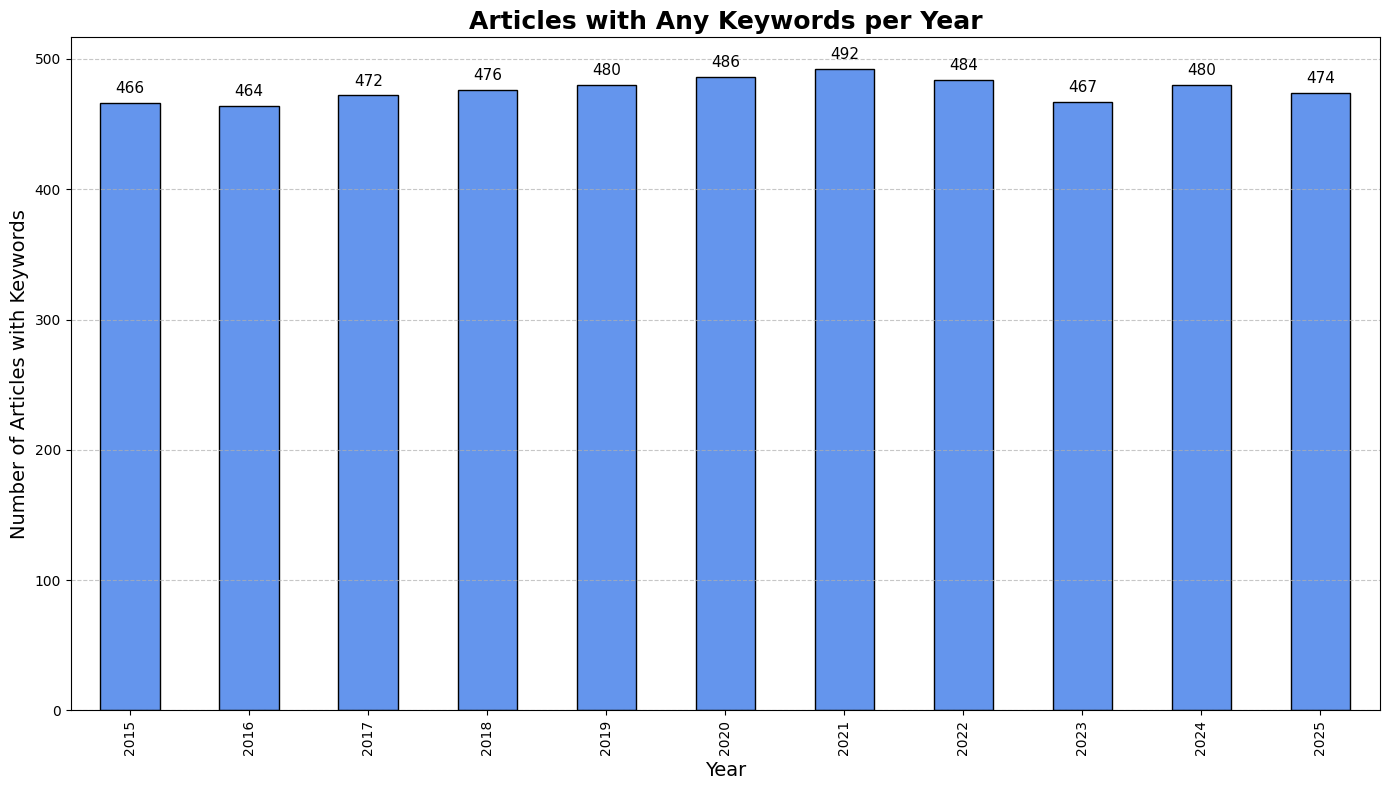

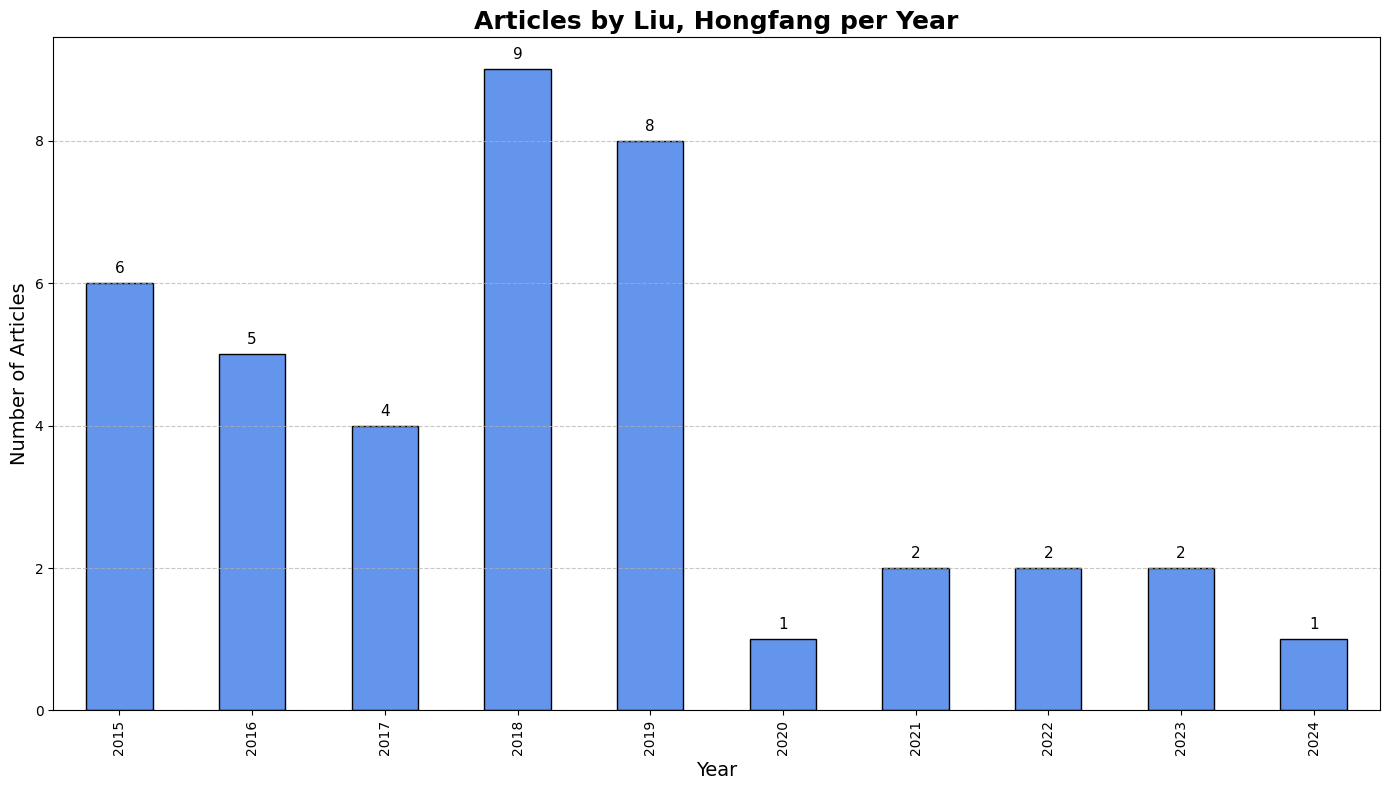

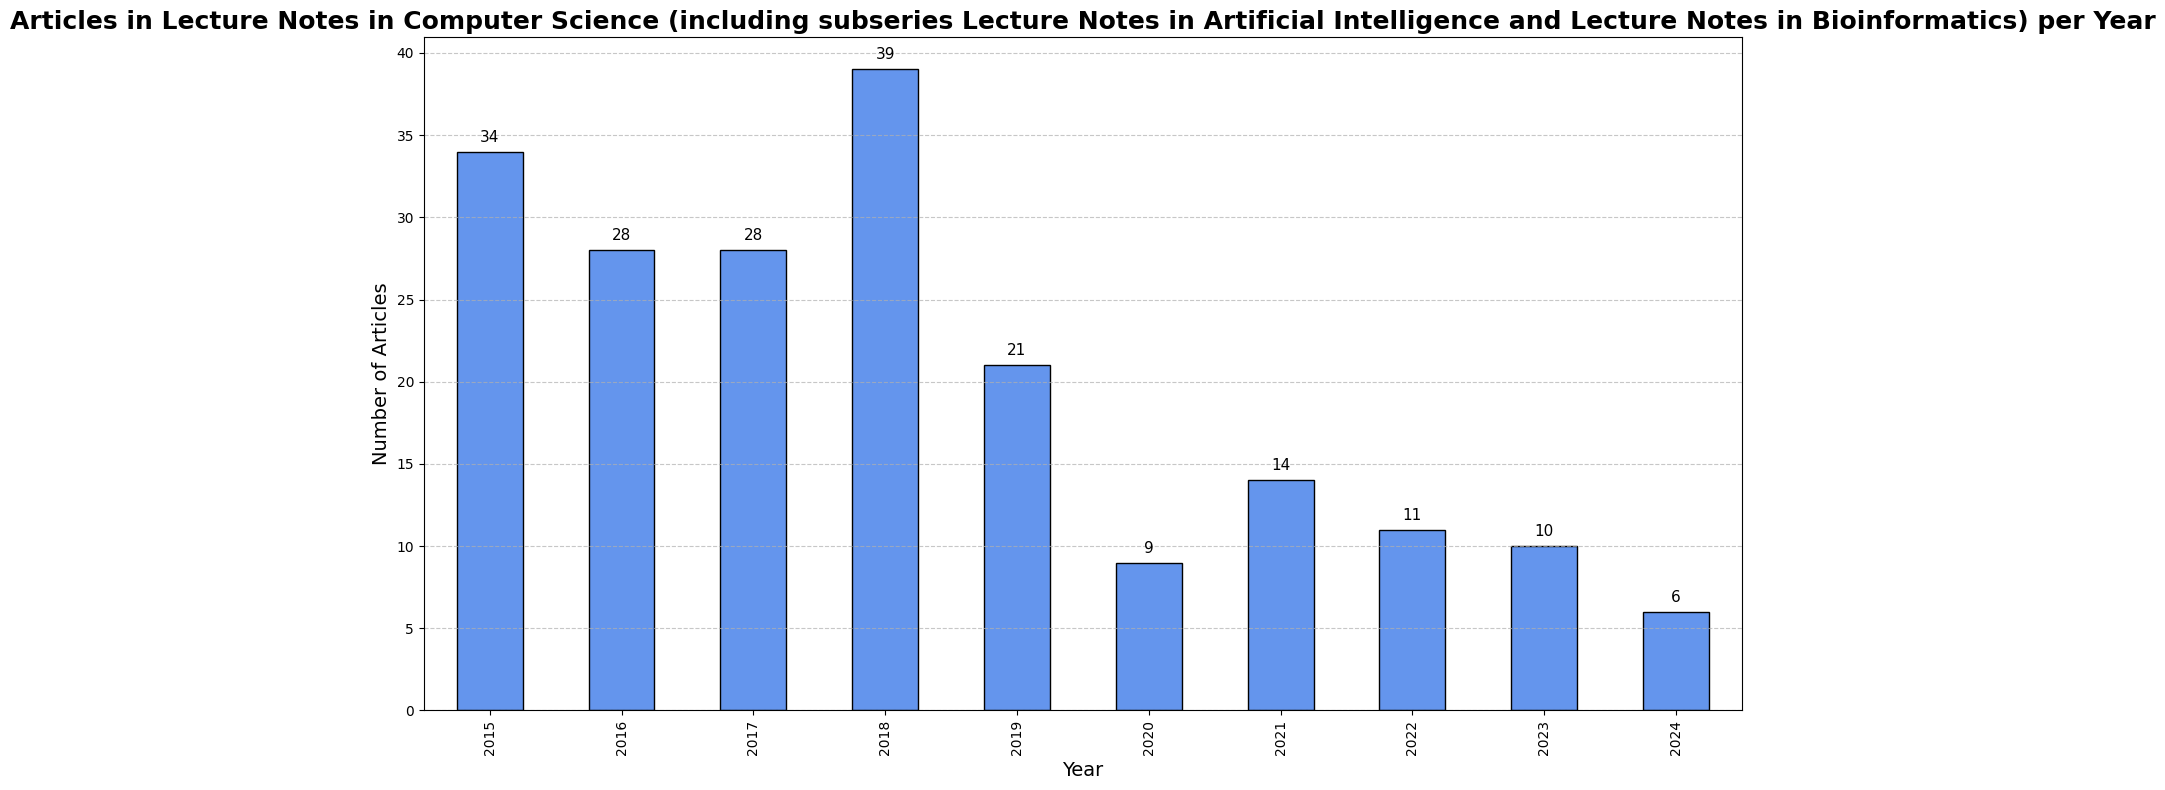

In [220]:
# show how much articles have keywords in each year
articles_df['Has Any Keywords'] = articles_df['Combined Keywords'].apply(lambda x: len(x) > 0)
articles_per_year_keywords = articles_df.groupby('Year')['Has Any Keywords'].value_counts().unstack().fillna(0)
articles_per_year_keywords = articles_per_year_keywords.sort_index()
create_bar_chart(articles_per_year_keywords[True], "Articles with Any Keywords per Year", "Year", "Number of Articles with Keywords")

# show how many articles were written by the top author in each year
top_author = top_authors.index[0]
top_author_articles = articles_df[articles_df['Author full names'].str.contains(top_author, na=False)]
top_author_per_year = top_author_articles['Year'].value_counts().sort_index()
create_bar_chart(top_author_per_year, f"Articles by {top_author} per Year", "Year", "Number of Articles")

# show how many articles were written by the top source in each year
top_source = top_sources.index[0]
top_source_articles = articles_df[articles_df['Source title'] == top_source]
top_source_per_year = top_source_articles['Year'].value_counts().sort_index()
create_bar_chart(top_source_per_year, f"Articles in {top_source} per Year", "Year", "Number of Articles")

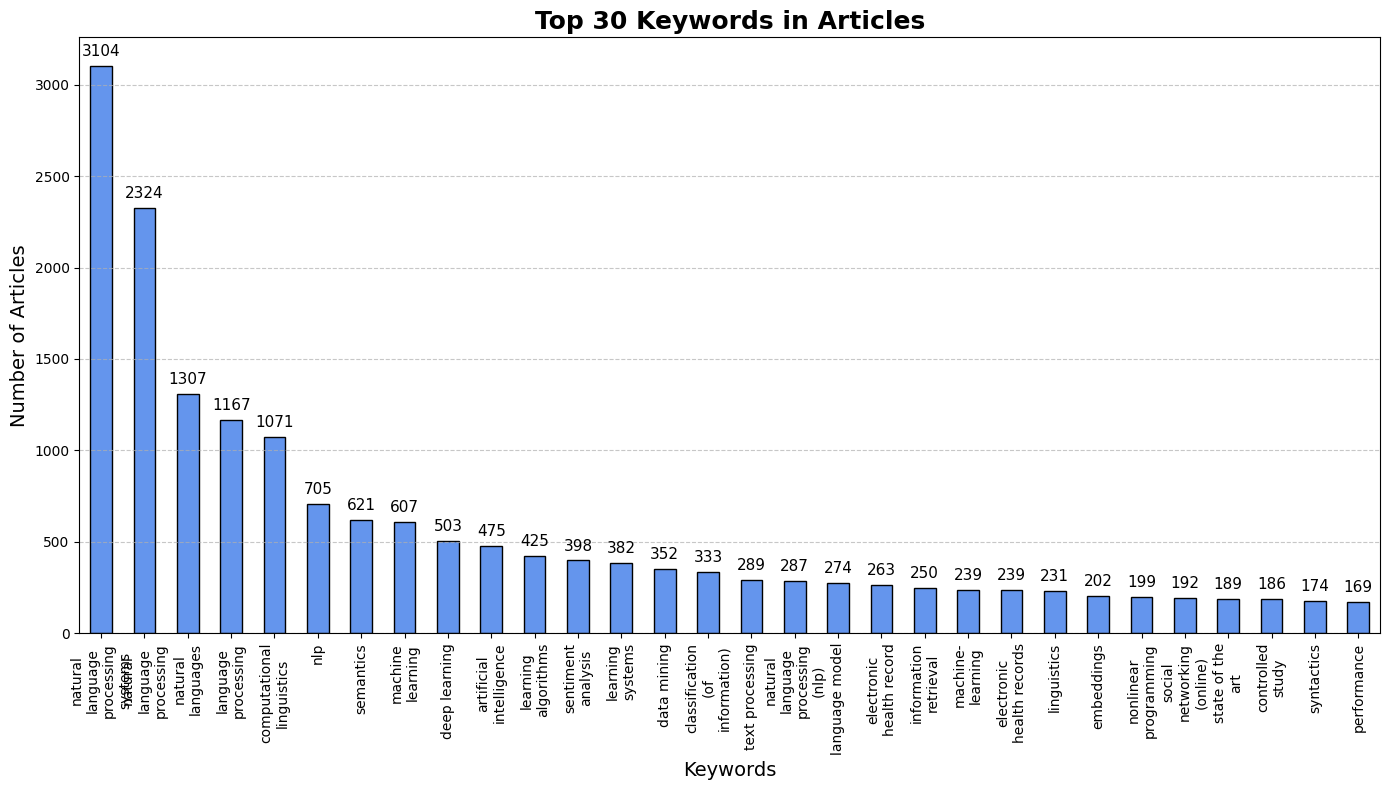

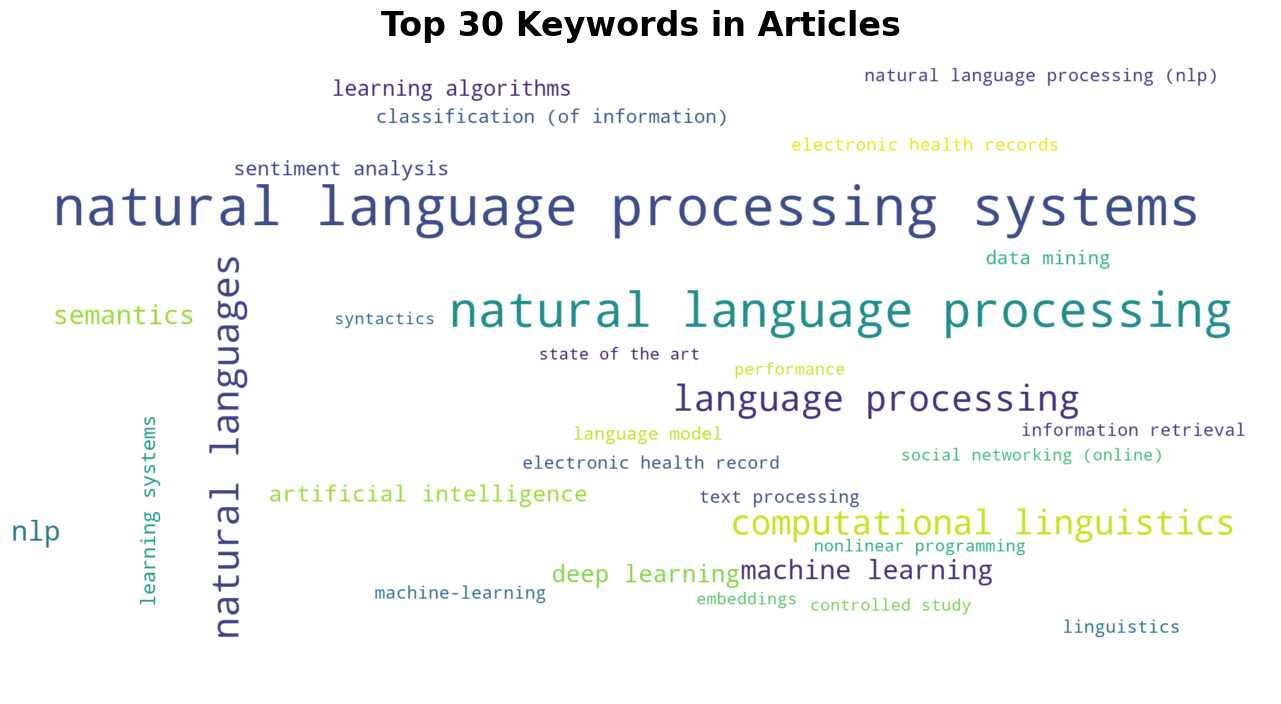

In [221]:
all_keywords = articles_df['Combined Keywords'].explode().dropna()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")

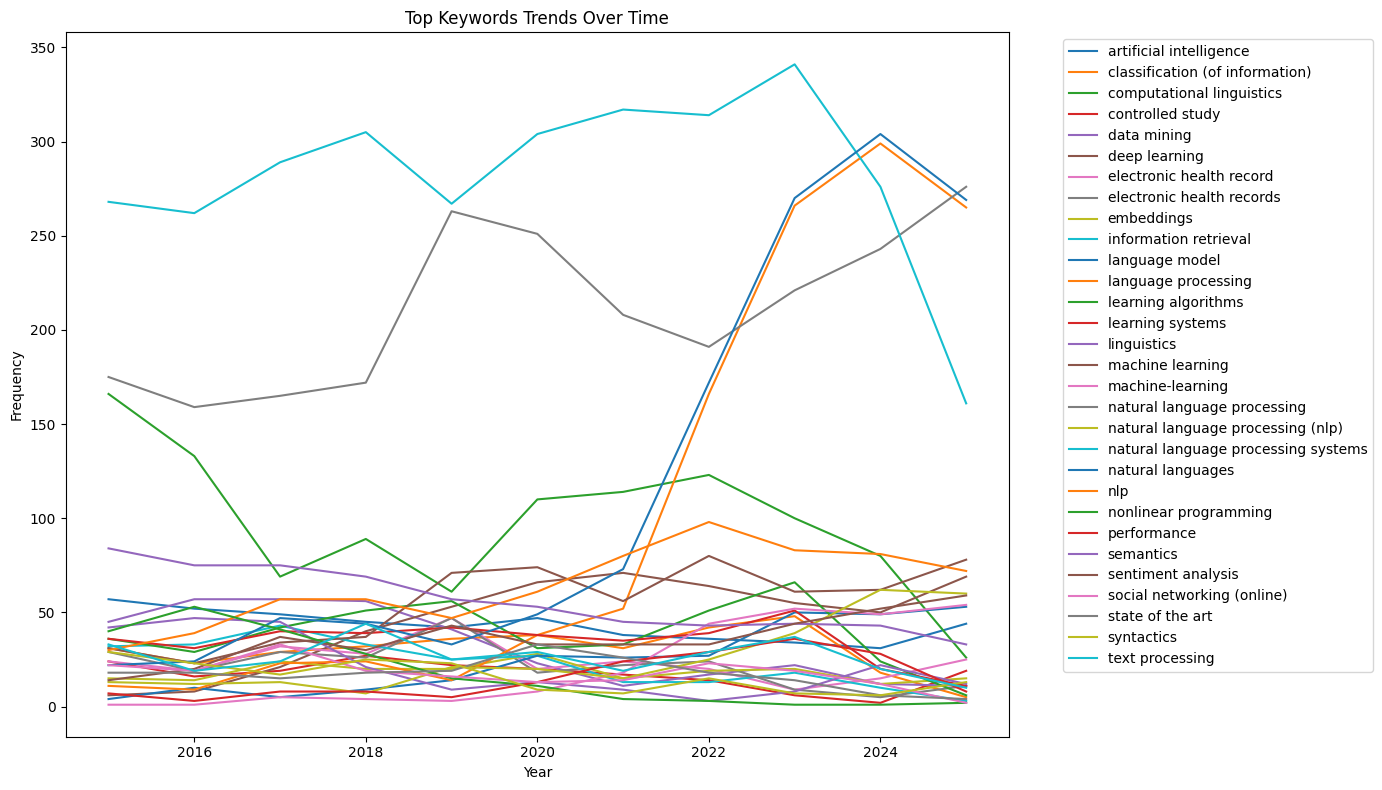

In [222]:
top_keywords = keyword_counts.index.tolist()[:30]

articles_df['Combined Keywords'] = articles_df['Combined Keywords'].apply(lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else [])
keywords_year_df = articles_df.explode('Combined Keywords')

keywords_year_df = keywords_year_df[keywords_year_df['Combined Keywords'].isin(top_keywords)]

trend_data = (
    keywords_year_df.groupby(['Year', 'Combined Keywords'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 8))
for keyword in trend_data.columns:
    plt.plot(trend_data.index, trend_data[keyword], label=keyword)

plt.title("Top Keywords Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [223]:
exploded_keywords_df = articles_df[['Combined Keywords']].explode('Combined Keywords')
exploded_keywords_df['Combined Keywords'] = exploded_keywords_df['Combined Keywords'].str.lower().str.strip()

binary_matrix = pd.crosstab(exploded_keywords_df.index, exploded_keywords_df['Combined Keywords'])
top_keywords = exploded_keywords_df['Combined Keywords'].value_counts().head(1500).index
filtered_matrix = binary_matrix[top_keywords]
correlation_matrix = filtered_matrix.corr(method='pearson')
# correlation_matrix = binary_matrix.corr(method='pearson')
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)


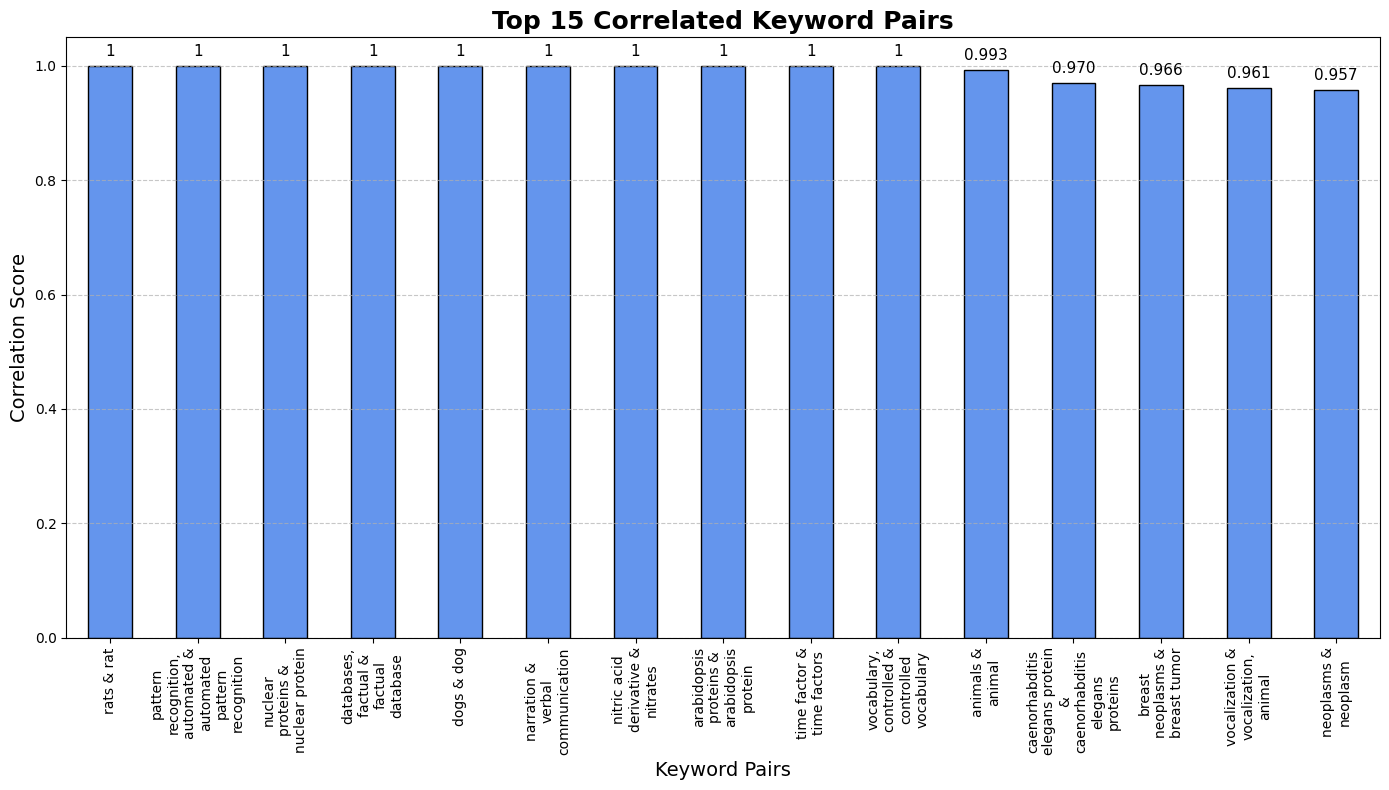

In [224]:
top_correlated_pairs = upper_triangle.stack().sort_values(ascending=False)

top_corr_pairs = top_correlated_pairs.head(15)

pair_labels = [f"{a} & {b}" for a, b in top_corr_pairs.index]
correlation_scores = top_corr_pairs.values

create_bar_chart(pd.Series(correlation_scores, index=pair_labels),
                  "Top 15 Correlated Keyword Pairs",
                    "Keyword Pairs", "Correlation Score")

In [232]:
keyword_year_df = articles_df[['Year', 'Combined Keywords']].explode('Combined Keywords')
keyword_year_df = keyword_year_df.dropna()

keyword_counts = keyword_year_df.groupby(['Combined Keywords', 'Year']).size().unstack(fill_value=0)

min_total_count = 30
total_counts = keyword_counts.sum(axis=1)
keyword_counts = keyword_counts[total_counts >= min_total_count]

z_scores = (keyword_counts - keyword_counts.mean(axis=1).values[:, None]) / keyword_counts.std(axis=1).values[:, None]
z_scores = z_scores.fillna(0)

top_z_keywords_per_year = {}
min_year_count = 10
for year in z_scores.columns:
    valid_keywords = keyword_counts[year] >= min_year_count
    filtered_z = z_scores[year][valid_keywords]
    top_keywords = filtered_z.sort_values(ascending=False).head(8)
    top_z_keywords_per_year[year] = top_keywords

keyword_only_dict = {
    year: list(keywords.index) for year, keywords in top_z_keywords_per_year.items()
}

trend_df_keywords = pd.DataFrame.from_dict(keyword_only_dict, orient='index')
trend_df_keywords.columns = [f"Place {i+1}" for i in range(trend_df_keywords.shape[1])]

display(trend_df_keywords)

,Place 1,Place 2,Place 3,Place 4,Place 5,Place 6,Place 7,Place 8
2015,information science,electronic medical record,genetics,classification,computational linguistics,dependency parsing,artificial intelligence,procedures
2016,ontology,optimal control systems,optimization,semantic web,nonlinear programming,knowledge management,nlp tools,linguistics
2017,education,software engineering,intelligent systems,social networking (online),requirements engineering,information retrieval,nlp tools,medical informatics
2018,recurrent neural networks,supervised learning,text processing,speech recognition,health care,long short-term memory,word embedding,reproducibility
2019,diagnostic imaging,gold standard,electronic health record,algorithm,electronic health records,major clinical study,pos tagging,reproducibility of results
2020,question answering,human experiment,embeddings,state of the art,named entity recognition,text mining,machine translations,deep neural networks
2021,large-scales,transfer learning,deep neural networks,covid-19,down-stream,nlp systems,pipelines,students
2022,parts-of-speech tagging,text data,support vector machines,forecasting,text classification,systematic review,covid-19,speech recognition
2023,e-learning,human language,case-studies,digital storage,transformers,performance,learning algorithms,classification (of information)
2024,machine translation,adversarial machine learning,text analysis,language processing techniques,economic and social effects,data handling,network security,contrastive learning


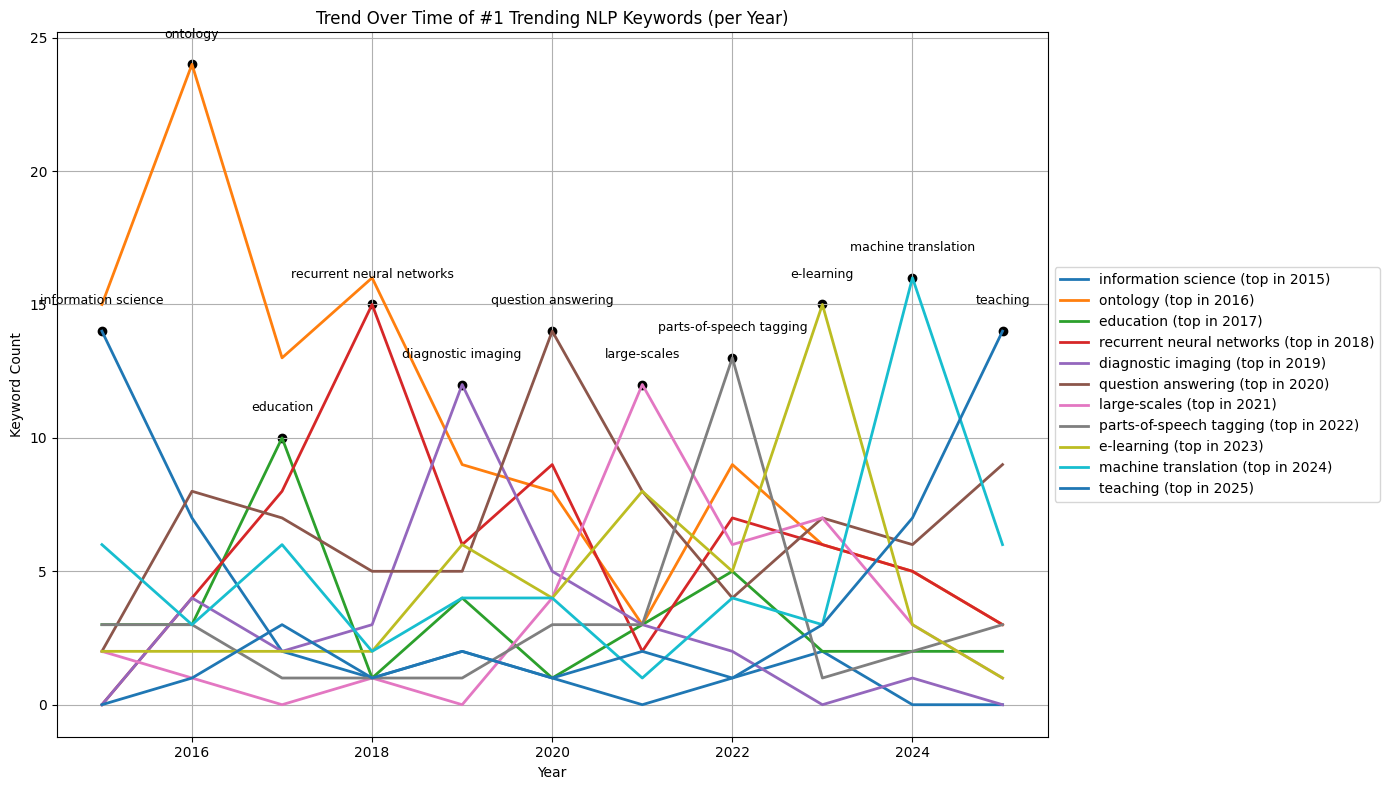

In [234]:
import matplotlib.pyplot as plt

top_keywords = trend_df_keywords["Place 1"]

plt.figure(figsize=(14, 8))

for year, keyword in top_keywords.items():
    if keyword in keyword_counts.index:
        counts = keyword_counts.loc[keyword]
        plt.plot(
            counts.index, counts.values,
            label=f"{keyword} (top in {year})",
            linewidth=2
        )
        peak_year = counts.idxmax()
        peak_value = counts.max()
        plt.scatter([peak_year], [peak_value], color='black')
        plt.text(peak_year, peak_value + 1, keyword, fontsize=9, ha='center')

plt.xlabel("Year")
plt.ylabel("Keyword Count")
plt.title("Trend Over Time of #1 Trending NLP Keywords (per Year)")
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [227]:
top_keywords_per_year = (
    keyword_year_df
    .groupby(['Year', 'Combined Keywords'])
    .size()
    .reset_index(name='count')
    .sort_values(['Year', 'count'], ascending=[True, False])
)

print("\nMost frequent keywords per year:")
for year in sorted(keyword_year_df['Year'].unique()):
    year_keywords = top_keywords_per_year[top_keywords_per_year['Year'] == year].head(15)
    print(f"\n{year}:")
    for _, row in year_keywords.iterrows():
        print(f"{row['Combined Keywords']}: {row['count']}")


Most frequent keywords per year:

2015:
natural language processing systems: 268
natural language processing: 175
computational linguistics: 166
semantics: 84
artificial intelligence: 57
data mining: 45
linguistics: 42
nonlinear programming: 40
learning algorithms: 36
learning systems: 36
procedures: 35
text processing: 33
information retrieval: 32
priority journal: 32
classification (of information): 31

2016:
natural language processing systems: 262
natural language processing: 159
computational linguistics: 133
semantics: 75
data mining: 57
nonlinear programming: 53
artificial intelligence: 52
linguistics: 47
nlp: 39
information retrieval: 33
learning systems: 31
learning algorithms: 29
natural languages: 24
ontology: 24
classification (of information): 23

2017:
natural language processing systems: 289
natural language processing: 165
semantics: 75
computational linguistics: 69
data mining: 57
nlp: 57
artificial intelligence: 49
natural languages: 47
linguistics: 45
information re

In [228]:
summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    try:
        summary = summarizer("summarize: " + text, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""
SUM_N = 30
summarized_abstracts = [summarize_text(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]


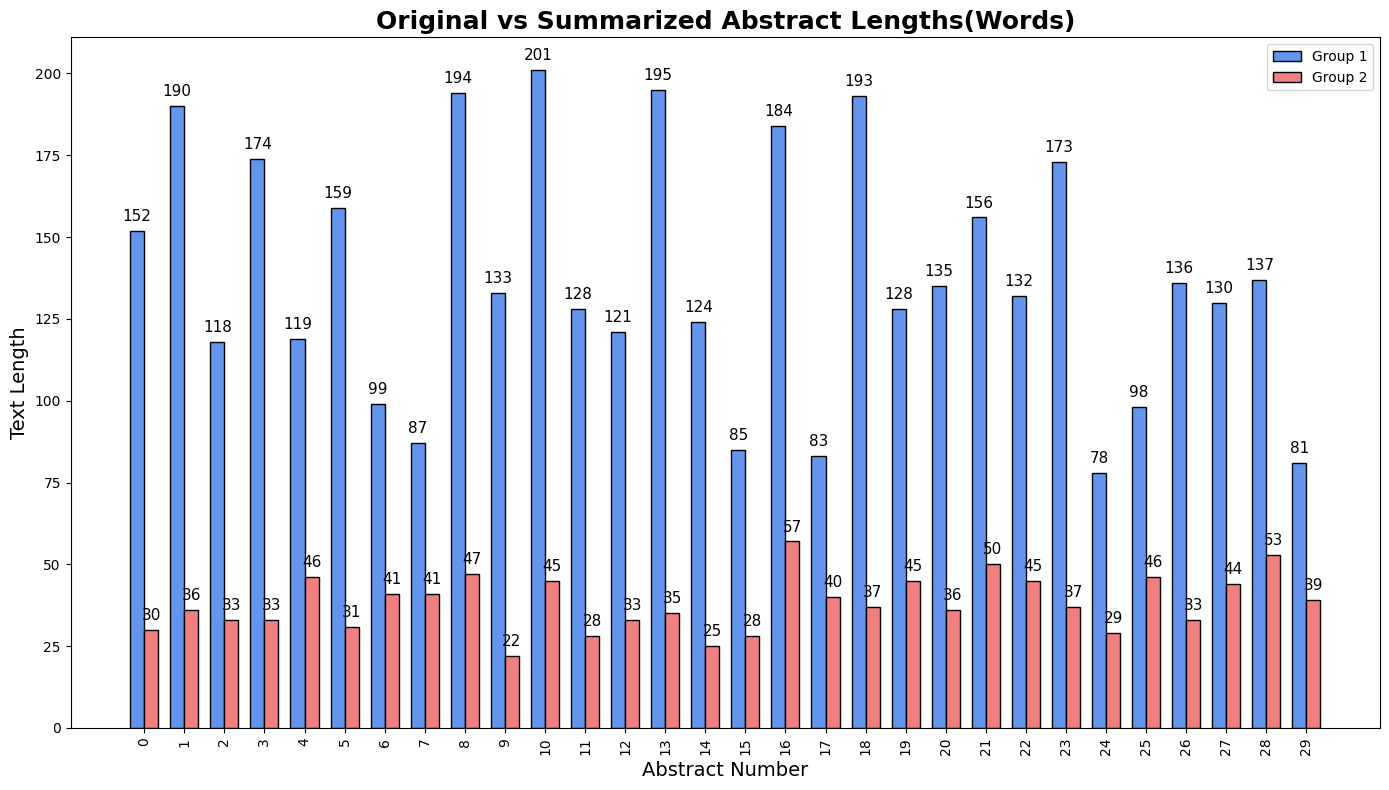

In [229]:
original_lengths = [len(abstract.split()) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]
summary_lengths = [len(summary.split()) for summary in summarized_abstracts if isinstance(summary, str)]


indices = range(len(original_lengths))

create_grouped_bar_chart(indices, original_lengths, summary_lengths,
                          "Original vs Summarized Abstract Lengths(Words)",
                            "Abstract Number", "Text Length")

In [230]:
top_articles_by_keyword = {}

def count_matches(article_keywords):
    return sum(kw in article_keywords for kw in trending_keywords)
for year in trend_df_keywords.index:
    if year not in articles_df['Year'].unique():
        continue
    trending_keywords = trend_df_keywords.loc[year].dropna().str.lower().tolist()
    year_articles = articles_df[articles_df['Year'] == year].copy()
    year_articles = year_articles.dropna(subset=["Combined Keywords"])
    year_articles["Combined Keywords"] = year_articles["Combined Keywords"].apply(lambda kws: [kw.lower() for kw in kws if isinstance(kw, str)])
    year_articles["match_score"] = year_articles["Combined Keywords"].apply(count_matches)
    top_matched = year_articles.sort_values("match_score", ascending=False).head(10)
    print(top_matched[['Title', 'match_score']])
    top_articles_by_keyword[year] = top_matched

                                                  Title  match_score
2356  Novel topic diffusion prediction using latent ...            5
2334  Identifying named entities from PubMed® for en...            5
2276  Predicting treatment relations with semantic p...            5
2036  BioHCDP: A hybrid constituency-dependency pars...            5
2278  Event extraction via dynamic multi-pooling con...            4
2140  Ontology-based information extraction with a c...            4
2296  Exploiting online human knowledge in Requireme...            4
2066  Arabic NLP tools for ontology construction fro...            4
2400  Chinese textual entailment recognition enhance...            4
2463  Natural language translation at the intersecti...            4
                                                  Title  match_score
2702  A Scalable Approach for Sentiment Analysis of ...            6
2579  Using automatically extracted information from...            5
2773  Event extraction via bidirec

In [235]:
summarized_per_year = {}
for year, top_df in top_articles_by_keyword.items():
    article_abstracts = top_df["Abstract"].dropna().astype(str).tolist()
    article_summaries = [summarize_text(abstract) for abstract in article_abstracts]
    final_summary = "\n".join(article_summaries)
    summarized_per_year[year] = final_summary
    print(f"{year}:\n{final_summary}\n")


2015:
predicting cross-topicobserved diffusions on big social media data is an emerging research domain . in real world social network, many diffusions to be predicted are actually unobservable . a learning-based framework is developed to solve the problem .
controlled vocabularies are widely used for biomedical natural language processing (NLP) tasks . the standard terminology in such collections suffers from low usage . only 13% of UMLS terms appear in MEDLINE® .
in vitro approaches are first attempted to identify promising candidates . in silico or computational approaches are also being employed to identify viable treatment options .
bioHCDP aims at enhancing the state of the art of biological text mining by applying novel linguistic computational techniques . we compared BioHCDP experimentally with three systems . results showed marked improvement .
traditional approaches to event extraction rely on elaborately designed features and complicated natural language processing tools . 

In [237]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()

def extract_topics_with_gpt(prompt_text,max_new_tokens=50):
    inputs = tokenizer.encode(prompt_text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.9,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

summarized_topics_per_year = {}
for year, combined in summarized_per_year.items():
    prompt = f"What are the main research topics discussed in the following abstracts?\n\n{combined}\n\nTopics:"
    gpt_output = extract_topics_with_gpt(prompt)
    if "Topics:" in gpt_output:
        gpt_output = gpt_output.split("Topics:")[-1].strip()
    summarized_topics_per_year[year] = gpt_output
    print(f"\n {year}:\n{gpt_output}\n")



 2015:
AI, human language , human language , human language , human language , human language , human language , human language , human language


 2016:
the world of NLP, NLP, and data mining are described in the following abstracts .
Abstractions:
NLP uses natural language processing to generate parsimony, semantic representation and Word-Sense for a variety of tasks .


 2017:
languages, linguistics, nLP, linguistics, nLP, nLP, nLP

by Andrew


 2018:
cognitive neuroscience, natural language processing, social media, health, computer science


 2019:
natural-language-processing, nLP, nLP, nLP, nLP, nLP


Advertisements


 2020:
text, speech, linguistics, statistics, data, human-resources


 2021:
science, software, research, human-interest, human-interest, animal-interest, environment, social sciences, genetics, human-interest, human-interest, public-interest, human-interest, human-interest, human-interest, language


 2022:
social media, science-and-technology, research-and-techno

In [238]:
nlp = spacy.load("en_core_web_sm")

def extract_keywords_spacy(text, top_n=5):
    doc = nlp(text.lower())
    chunks = [chunk.text.strip() for chunk in doc.noun_chunks if len(chunk.text.strip()) > 2]
    entities = [ent.text.strip() for ent in doc.ents if ent.label_ in {"ORG", "PRODUCT", "EVENT", "WORK_OF_ART", "TECHNOLOGY"}]
    all_phrases = chunks + entities
    counts = Counter(all_phrases)
    keywords = [kw for kw, _ in counts.most_common() if kw not in nlp.Defaults.stop_words]
    return keywords[:top_n]
cleaned_topics = {}

for year, summary in summarized_topics_per_year.items():
    if isinstance(summary, str) and summary.strip():
        keywords = extract_keywords_spacy(summary)
        cleaned_topics[year] = keywords
    else:
        cleaned_topics[year] = []

# Create a nice DataFrame
topics_df = pd.DataFrame.from_dict(cleaned_topics, orient='index')
topics_df.columns = [f"Place {i+1}" for i in range(topics_df.shape[1])]
topics_df.index.name = "Year"
display(topics_df)


,Place 1,Place 2,Place 3,Place 4,Place 5
Year,,,,,
2015,None,None,None,None,None
2016,nlp,the world,data mining,the following abstracts,abstractions
2017,nlp,linguistics,languages,andrew,None
2018,cognitive neuroscience,natural language processing,social media,health,computer science
2019,"natural-language-processing, nlp, nlp, nlp, nl...",None,None,None,None
2020,text,speech,linguistics,statistics,data
2021,human-interest,science,software,research,animal-interest
2022,social media,australia,None,None,None
2023,the research and publication committee,None,None,None,None
